# Create a network

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [2]:
# Loading up the data
# Note, that the data is space-separated and very "raw"
# also need to skip the header and cut off the first column

attributes = pd.read_csv('Krack-High-Tec-Attributes.csv')
attributes.columns = [column.lower() for column in attributes.columns]

el_advice = pd.read_csv('Krack-High-Tec-edgelist-Advice.txt', sep=' ', header = None)
el_advice = el_advice.iloc[:,1:]
el_advice.columns = ['ego', 'alter', 'advice_tie']

el_friendship = pd.read_csv('Krack-High-Tec-edgelist-Friendship.txt', sep=' ', header = None)
el_friendship = el_friendship.iloc[:,1:]
el_friendship.columns = ['ego', 'alter', 'friendship_tie']

el_reports = pd.read_csv('Krack-High-Tec-edgelist-ReportsTo.txt', sep=' ', header = None)
el_reports = el_reports.iloc[:,1:]
el_reports.columns = ['ego', 'alter', 'reports_tie']

In [3]:
print(el_advice.head())
print(el_friendship.head())
print(el_reports.head())
print(attributes.head())

   ego  alter  advice_tie
0    1      1           0
1    1      2           1
2    1      3           0
3    1      4           1
4    1      5           0
   ego  alter  friendship_tie
0    1      1               0
1    1      2               1
2    1      3               0
3    1      4               1
4    1      5               0
   ego  alter  reports_tie
0    1      1            0
1    1      2            1
2    1      3            0
3    1      4            0
4    1      5            0
   id  age  tenure  level  dept
0   1   33   9.333      3     4
1   2   42  19.583      2     4
2   3   40  12.750      3     2
3   4   33   7.500      3     4
4   5   32   3.333      3     2


In [4]:
# Rounding helps later on when dealing with assortativity
attributes = attributes.round().astype(int)

In [5]:
# Create DIRECTED graph, we use Di for that.
G = nx.DiGraph()

In [6]:
# Filter for those entries where a specific tie exists (subset of pandas DF)
el_reports_1 = el_reports[el_reports.reports_tie == 1]

# Growing graph by ADDING edges (as a list of tuple --> zip 2 columns of the DF), adding arguments/labels is very open in networkx,
# thats why we can just write reports_tie as an argument and set it to 1
# some edges will have more than one type of tie

G.add_edges_from(zip(el_reports_1.ego, el_reports_1.alter), reports_tie=1)

# and the same below 2 more times for the other graphs

In [7]:
el_friendship_1 = el_friendship[el_friendship.friendship_tie == 1]
G.add_edges_from(zip(el_friendship_1.ego, el_friendship_1.alter), friendship_tie=1)

In [8]:
el_advice_1 = el_advice[el_advice.advice_tie == 1]
G.add_edges_from(zip(el_advice_1.ego, el_advice_1.alter), advice_tie=1)

In [9]:
# Setting the NODE attributes

# Setting the index as id
attributes.set_index('id', inplace=True)

# Creating a dictionary from the Dataframe transponse that we can pass as note attributes for our graph
attributes_dict = attributes.T.to_dict()

# Setting node attributes

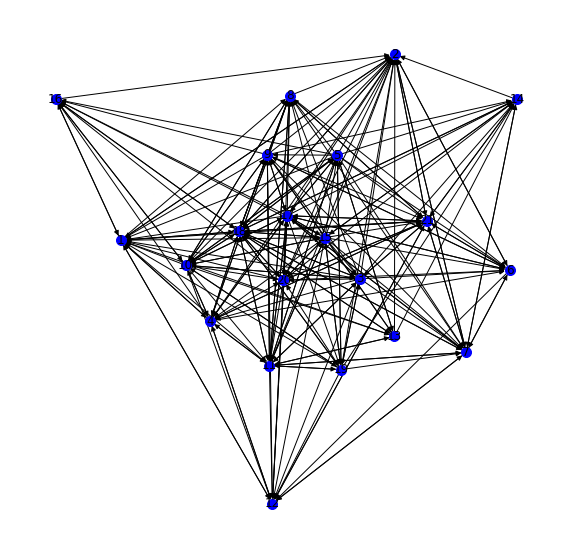

In [10]:
# A not too pretty first viz (of the full Graph with all edges imported)
plt.figure(figsize=(10, 10))
pos=nx.spring_layout(G, k=0.15)
nx.draw_networkx(G,pos,node_size=100, node_color='blue')
plt.axis('off') # We don't need axis
plt.show()

In [11]:
nx.info(G)

'DiGraph with 21 nodes and 232 edges'

# Analysis

## A: Network level characteristics.

### Density, Transistivity (Clustering Coefficient) and Reciprocity

In [12]:
print('Density')
print(nx.density(G))
print()
print('Transitivity')
print(nx.transitivity(G))
print()
print('Reciprocity')
print(nx.reciprocity(G))

Density
0.5523809523809524

Transitivity
0.5609929078014184

Reciprocity
0.6293103448275862


### Are relationships like friendship and advice giving usually reciprocal?

### Are friends of your friends also your friends?

### Are the employees generally more likely to be in a friendship or advice-seeking relationship?

In [13]:
def print_nw_measures(G):
  print('Density')
  print(nx.density(G))
  print()
  print('Transitivity')
  print(nx.transitivity(G))
  print()
  print('Reciprocity')
  print(nx.reciprocity(G))

In [14]:
ties = ['advice_tie', 'friendship_tie', 'reports_tie']

for tie in ties:
  G_sub = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if tie in d.keys()])
  print('########')
  print('Tie type: ' + tie )
  print_nw_measures(G_sub)

########
Tie type: advice_tie
Density
0.4523809523809524

Transitivity
0.4651600753295669

Reciprocity
0.47368421052631576
########
Tie type: friendship_tie
Density
0.24285714285714285

Transitivity
0.27581863979848864

Reciprocity
0.45098039215686275
########
Tie type: reports_tie
Density
0.047619047619047616

Transitivity
0

Reciprocity
0.0


## B: Node level characteristics.

### Who is most popular in the networks. Who is the most wanted friend, and advice giver?

### Are managers in higher hirarchy more popular as friend, and advice giver?

In [15]:
# Finding the most popular person in the 3 sub-networks
ties = ['advice_tie', 'friendship_tie', 'reports_tie']

for tie in ties:
  G_sub = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if tie in d.keys()])
  in_degrees = nx.in_degree_centrality(G_sub)
  # a quick transformation to pandas Series
  in_degrees_series = pd.Series(in_degrees)
  max_degree = in_degrees_series.max()
  print('####')
  print('Tie type: ' + tie)
  print(in_degrees_series[in_degrees_series == max_degree])

####
Tie type: advice_tie
2    0.9
dtype: float64
####
Tie type: friendship_tie
2    0.5
dtype: float64
####
Tie type: reports_tie
14    0.35
dtype: float64


In [16]:
# More power more popularity ?
for tie in ties:
  G_sub = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if tie in d.keys()])
  in_degrees = nx.in_degree_centrality(G_sub)
  # a quick transformation to pandas Series
  in_degrees_series = pd.Series(in_degrees)
  print('####')
  print('Tie type: ' + tie)
  print(pd.concat([attributes, in_degrees_series], axis=1).groupby(by='level')[0].mean())

####
Tie type: advice_tie
level
1    0.650000
2    0.725000
3    0.371875
Name: 0, dtype: float64
####
Tie type: friendship_tie
level
1    0.150000
2    0.300000
3    0.234375
Name: 0, dtype: float64
####
Tie type: reports_tie
level
1    0.2
2    0.2
3    0.0
Name: 0, dtype: float64


In [17]:
group_types_nodept = attributes.columns[:-1]

In [18]:
group_types_nodept

Index(['age', 'tenure', 'level'], dtype='object')

## C: Relational Characteristics.

### Are managers from the same 1. department, or on the same 2. hirarchy, 3. age, or 4. tenuere more likely to become friends or give advice? (hint: assortiativity related)

### Are friends more likely to give each others advice?

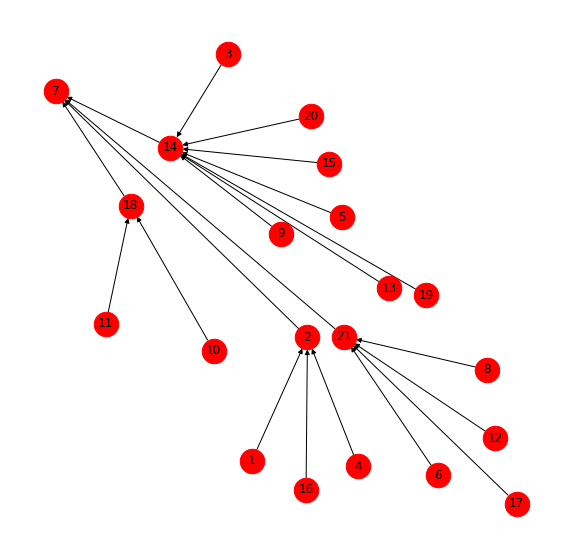

In [19]:
# See the hierarchy
G_rep = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if 'reports_tie' in d.keys()])
plt.figure(figsize=(10, 10))
pos=nx.spring_layout(G_rep, k=0.08)
nx.draw_networkx(G_rep,pos,node_size=600, node_color='red')
plt.axis('off')

plt.show()

In [21]:
# homophily within groups

for tie in ties:
  G_sub = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if tie in d.keys()])
  print('#######')
  print(tie)
  for x in group_types_nodept:
    print(x)
    print(nx.numeric_assortativity_coefficient(G_sub,x))
  print('dept')
  print(nx.attribute_assortativity_coefficient(G_sub,'dept')) 

#######
advice_tie
age


KeyError: ignored

In [22]:
partitions = []

for x in sorted(attributes.dept.unique()):
  partitions.append(list(attributes[attributes.dept == x].index))
  
ties_new = ['friendship_tie', 'advice_tie']

In [23]:
print(partitions)
print(ties_new)

[[7], [6, 8, 12, 17, 21], [3, 5, 9, 13, 14, 15, 19, 20], [10, 11, 18], [1, 2, 4, 16]]
['friendship_tie', 'advice_tie']


In [24]:
Graphs = []
for tie in ties_new:
  G_sub = G.edge_subgraph([(u,v) for u,v,d in G.edges(data=True) if tie in d.keys()])
  agg_nw = nx.quotient_graph(G_sub, partitions, relabel = True)
  Graphs.append(agg_nw)
  print(pd.DataFrame(list(agg_nw.edges(data=True))))

    0  1               2
0   1  0   {'weight': 2}
1   1  2  {'weight': 12}
2   1  3   {'weight': 8}
3   1  4  {'weight': 15}
4   2  0   {'weight': 1}
5   2  1  {'weight': 12}
6   2  3  {'weight': 16}
7   2  4   {'weight': 4}
8   3  1   {'weight': 8}
9   3  2  {'weight': 16}
10  3  4   {'weight': 6}
11  4  1  {'weight': 15}
12  4  3   {'weight': 6}
    0  1               2
0   0  1   {'weight': 8}
1   0  2   {'weight': 7}
2   0  3   {'weight': 4}
3   0  4   {'weight': 2}
4   1  0   {'weight': 8}
5   1  2  {'weight': 28}
6   1  3   {'weight': 8}
7   1  4  {'weight': 16}
8   2  0   {'weight': 7}
9   2  1  {'weight': 28}
10  2  3  {'weight': 33}
11  2  4  {'weight': 22}
12  3  0   {'weight': 4}
13  3  1   {'weight': 8}
14  3  2  {'weight': 33}
15  3  4  {'weight': 16}
16  4  0   {'weight': 2}
17  4  1  {'weight': 16}
18  4  2  {'weight': 22}
19  4  3  {'weight': 16}


# Visualization

## Everything goes. Show us some pretty and informative plots. Choose what to plot, and how, on your own. Interpret the results and share some insights.

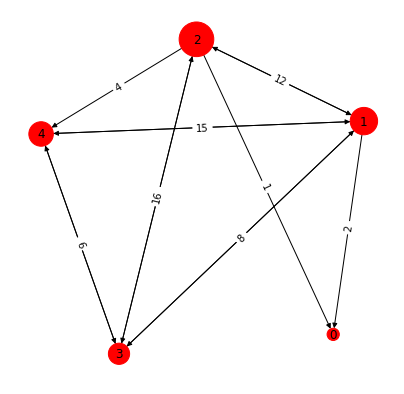

In [25]:
# plotting graph
node_size = [Graphs[0].nodes[x]['nnodes'] * 150 for x in Graphs[0].nodes()]
plt.figure(figsize=(7, 7))
pos=nx.spring_layout(Graphs[0], k=70)
nx.draw_networkx(Graphs[0],pos,node_size=node_size, node_color='red', with_labels=True) # adding node_size
labels = nx.get_edge_attributes(Graphs[0],'weight') # I want to se weight of edges as number
nx.draw_networkx_edge_labels(Graphs[0],pos,edge_labels=labels) # Setting labels of edges using our variable
plt.axis('off') # We don't need axis
plt.show()

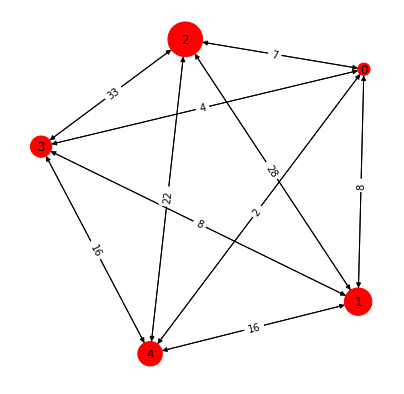

In [26]:
# plotting graph
node_size = [Graphs[1].nodes[x]['nnodes'] * 150 for x in Graphs[1].nodes()]
plt.figure(figsize=(7, 7))
pos=nx.spring_layout(Graphs[1], k=70)
nx.draw_networkx(Graphs[1],pos,node_size=node_size, node_color='red', with_labels=True) # adding node_size
labels = nx.get_edge_attributes(Graphs[1],'weight') # I want to se weight of edges as number
nx.draw_networkx_edge_labels(Graphs[1],pos,edge_labels=labels) # Setting labels of edges using our variable
plt.axis('off') # We don't need axis
plt.show()